In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
np.random.seed(555)
import pystan

In [41]:
stan_code = """

data {
    int N;
    real X[N];
    real Y[N];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(a + b*X[n], sigma);
    }
}
"""

In [3]:
import pandas as pd

salary_data = pd.read_csv('../data/data_salary.csv')

In [14]:
n_data = len(salary_data)
stan_data = {
    'N': n_data,
    'X': salary_data.X,
    'Y': salary_data.Y
}

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_132742f5a0acda2fbbda90aefa7afd12 NOW.


In [15]:
results = stan_model.sampling(data=stan_data, iter=1000, chains=4, seed=555, thin=1, warmup=100, n_jobs=-1)
results

Inference for Stan model: anon_model_132742f5a0acda2fbbda90aefa7afd12.
4 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=3600.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -117.7    3.74  70.82 -247.9 -162.6 -118.9 -73.42  23.29    358   1.01
b      21.88    0.08   1.59  18.53  20.87  21.94  22.92  24.77    365   1.01
sigma  84.77     0.3  15.36  60.89   73.7  82.91  93.51 119.73   2690    1.0
lp__  -93.59    0.05   1.25 -96.84 -94.17 -93.25 -92.66 -92.15    695    1.0

Samples were drawn using NUTS at Sat Feb  3 12:06:27 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

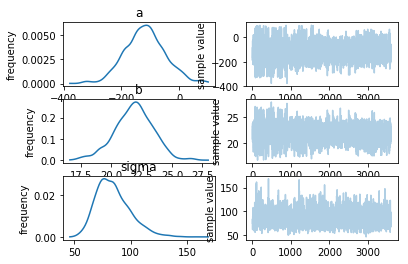

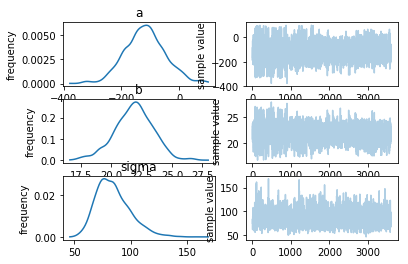

In [16]:
results.plot()

In [26]:
samples = results.extract()

a = np.mean(samples['a'])
b = np.mean(samples['b'])

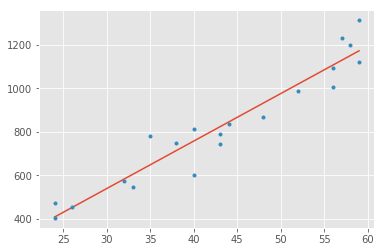

In [35]:
plt.plot(salary_data.X, a+b*salary_data.X)
plt.plot(salary_data.X, salary_data.Y, '.')

## Stan内部で回帰もする

In [42]:

stan_code_all_in = """

data {
    int N;
    real X[N];
    real Y[N];
    int N_out;
    real X_out[N_out];
    real Y_out[N_out];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

transformed parameters {
    real y_base[N];
    for (n in 1:N)
        y_base[n] = a + b*X[n];
}


model {
    for (n in 1:N) {
        Y[n] ~ normal(y_base[n], sigma);
    }
}

generated quantities {
    real y_base_out[N_out];
    real y_out[N_out];
    for (n in 1:N_out) {
        y_base_out[n] = a + b*X_out[n];
        y_out[n] = normal_rng(y_base_out[n], sigma);
    }
}

"""

In [46]:
stan_model = pystan.StanModel(model_code=stan_code_all_in)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70d0511a3f8fc97e1cdd092ef7301b96 NOW.


In [62]:
n_split = 10
n_data = len(salary_data.X[:n_split])
stan_data = {
    'N': n_data,
    'X': salary_data.X[:n_split],
    'Y': salary_data.Y[:n_split],
    'N_out': len(salary_data.X[n_split:]),
    'X_out': salary_data.X[n_split:],
    'Y_out': salary_data.Y[n_split:],
}

results_all_in = stan_model.sampling(data=stan_data, iter=1000, chains=4, seed=555, thin=1, warmup=100, n_jobs=-1)
results_all_in

Inference for Stan model: anon_model_70d0511a3f8fc97e1cdd092ef7301b96.
4 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=3600.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a             -27.86    9.43 157.72 -369.5 -130.3 -21.46  79.83 283.09    280   1.01
b              19.34    0.27   4.61   10.6   16.3  19.21  22.32  29.16    290   1.01
sigma          95.79    0.83  29.34  57.52  75.57  89.77 109.03 168.94   1255    1.0
y_base[0]     436.35    2.98  54.24 329.12 401.63 437.04 470.44 540.08    331   1.01
y_base[1]     436.35    2.98  54.24 329.12 401.63 437.04 470.44 540.08    331   1.01
y_base[2]     475.04    2.46   47.1 381.02 444.93 475.51 503.92 565.65    368    1.0
y_base[3]     591.09    0.99  32.66 525.95  571.5 591.28 609.72 658.77   1083    1.0
y_base[4]     610.43    0.82  31.99 547.56 591.37 610.19  628.5 675.66   1539    1.0
y_base[5]     649.12    0.67  32.62 586.34  629.

In [63]:
samples = results_all_in.extract()

y_base = np.mean(samples['y_base'], axis=0)

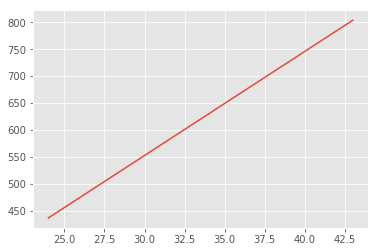

In [65]:
plt.plot(salary_data.X[:10], y_base)

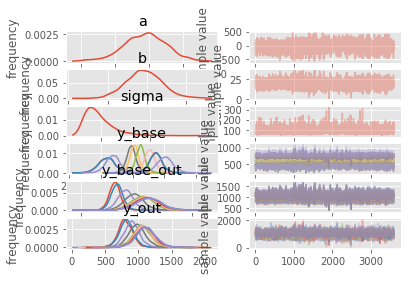

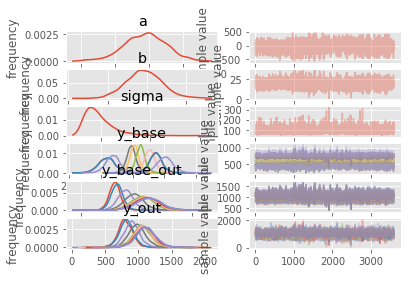

In [67]:
results_all_in.plot()

In [68]:
results_all_in.get_adaptation_info()

['# Adaptation terminated\n# Step size = 0.218183\n# Diagonal elements of inverse mass matrix:\n# 1, 1, 1\n',
 '# Adaptation terminated\n# Step size = 0.217861\n# Diagonal elements of inverse mass matrix:\n# 1, 1, 1\n',
 '# Adaptation terminated\n# Step size = 0.248228\n# Diagonal elements of inverse mass matrix:\n# 1, 1, 1\n',
 '# Adaptation terminated\n# Step size = 0.236897\n# Diagonal elements of inverse mass matrix:\n# 1, 1, 1\n']